## Libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/

Mounted at /gdrive
/gdrive/My Drive


In [ ]:
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

import cmdstanpy
cmdstanpy.install_cmdstan()

cmdstan_path()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpeb3vbdub
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


'/root/.cmdstan/cmdstan-2.31.0'

## Data preprocessing

In [ ]:
import pandas as pd
data = pd.read_csv("viagggi_individui_2014_2021.txt")

In [ ]:
# select years 2019 and 2021

mask = data.annrif != 2014
mask2 = data.annrif != 2015
mask3 = data.annrif != 2016
mask4 = data.annrif != 2018
mask5 = data.annrif != 2020
res = mask * mask2 * mask3 * mask4 * mask5 
data1 = data[res].drop("Unnamed: 0",axis = 1).fillna(-1)
data = data1

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data_2 = data[data.annrif == 2019]
m = data_2.DURATA > 0
data_2_trav = data_2[m]
print(data_2_trav.shape)
data_2_notrav = data_2[~m]
print(data_2_notrav.shape)
data_2_trav = data_2_trav.sample(n=1300, random_state=1)
data_2_notrav = data_2_notrav.sample(n=1300, random_state=1)
print(data_2_trav.shape)
print(data_2_notrav.shape)

data_3 = data[data.annrif == 2021]
m = data_3.DURATA > 0
data_3_trav = data_3[m]
print(data_3_trav.shape)
data_3_notrav = data_3[~m]
print(data_3_notrav.shape)
data_3_trav = data_3_trav.sample(n=1300, random_state=1)
data_3_notrav = data_3_notrav.sample(n=1300, random_state=1)
print(data_3_trav.shape)
print(data_3_notrav.shape)

data_ = pd.concat([data_2_trav,data_2_notrav,data_3_trav,data_3_notrav])
data = data_

(4393, 25)
(38801, 25)
(1300, 25)
(1300, 25)
(4284, 25)
(60602, 25)
(1300, 25)
(1300, 25)


In [ ]:
df = pd.DataFrame()

Select covariates:


*   civil state
*   region of origin
*   education level

and perform one-hot encoding (baseline: unmarried, north-west, elementary school)



In [ ]:
# civil state
name = "staciv4"
cols = ["married","divorced","widowed"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
# region of origin
name = "rip"
cols = ["North-East","Center","South","Islands"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
# education level
name = "istr4"
cols = ["middle school","high school","university"]

enc = OneHotEncoder()
or_val = data[name]
or_val = or_val.values.reshape(-1,1)
t_val = enc.fit(or_val).transform(or_val)
t_val = t_val.toarray()
t_val = t_val[:,1:]
df_temp = pd.DataFrame(t_val)
df_temp.columns = cols

df[cols] = df_temp

In [ ]:
print(df.shape)

(5200, 10)


## STAN

In [ ]:
# STAN model

model_stan_full = """

    data {

      // number of samples, divided between travelers and non-travelers
      int<lower=0> n_samples_trav;
      int<lower=0> n_samples_notrav;
      // number of covariates
      int<lower=0> p1;
      // covariates matrix 
      matrix[n_samples_trav,p1] X_trav;
      matrix[n_samples_notrav,p1] X_notrav;

    }

    parameters {

      // coefficients for parameter theta of probit model (non-centered reparametrization)
      vector[p1] beta_theta_raw;

    }
    
    transformed parameters {

      // true beta_theta
      vector[p1] beta_theta;
      beta_theta = 10.0 * beta_theta_raw;
      // theta computation, divided between travelers and non travelers
      vector[n_samples_trav] theta_trav;
      theta_trav = X_trav * beta_theta;
      vector[n_samples_notrav] theta_notrav;
      theta_notrav = X_notrav * beta_theta;

    }


    model {

      target += log(Phi_approx(theta_notrav));
      target += log1m(Phi_approx(theta_trav));

      // priors: 
      beta_theta_raw ~ std_normal();

    }

"""

In [ ]:
stan_file = "./full_test.stan"

with open(stan_file, "w") as f:
    print(model_stan_full, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/full_test
09:38:32 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/full_test.stan to exe file /gdrive/MyDrive/full_test
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/full_test.stan to exe file /gdrive/MyDrive/full_test
DEBUG:cmdstanpy:cmd: make /gdrive/MyDrive/full_test
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/gdrive/MyDrive/full_test.hpp /gdrive/MyDrive/full_test.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno

In [ ]:
# "auto-format" flag to fix deprecated delcarations

stan_model.format(
    overwrite_file = True,
    canonicalize = True,
    backup = False
)

In [ ]:
# STAN data preparation

data.loc[data["DURATA"] == -1,"DURATA"] = 0
Y = np.array(data["DURATA"],dtype = int)
X = df
print(X.columns)
X = np.column_stack([np.ones_like(Y), X])
print(Y.shape)
print(X.shape)
print(sum(np.isnan(X)))

Index(['married', 'divorced', 'widowed', 'North-East', 'Center', 'South',
       'Islands', 'middle school', 'high school', 'university'],
      dtype='object')
(5200,)
(5200, 11)
[0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
y_trav = Y[Y>=1]
x_trav = X[Y>=1,:]
y_trav = np.full(shape = len(y_trav),fill_value = 1)
year_len = int(X.shape[0]/3)
year_pos_len = int(len(y_trav)/3)
x_pos = X[Y==0,:]
y_pos = np.full(shape = x_pos.shape[0],fill_value = 0)
print(x_trav.shape,len(y_trav))
print(x_pos.shape,len(y_pos))

(2600, 11) 2600
(2600, 11) 2600


In [ ]:
stan_data = {
    "n_samples_trav": len(y_trav),
    "n_samples_notrav": x_pos.shape[0],
    "p1": X.shape[1],
    "X_trav": x_trav,
    "X_notrav": x_pos
}

In [ ]:
# STAN computations

stan_test_fit = stan_model.sample(data=stan_data, chains=4, parallel_chains=4, 
                             iter_warmup=3000, iter_sampling=2000,
                             adapt_delta=0.9,
                             inits = 0,
                             show_console=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcspjifga/1vxllvry.json
DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/full_test info
cwd: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/full_test', 'id=1', 'random', 'seed=85452', 'data', 'file=/tmp/tmpcspjifga/1vxllvry.json', 'init=0', 'output', 'file=/tmp/tmpcspjifga/full_testlx1fuq7k/full_test-20221222093905_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=3000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
09:39:05 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/full_test', 'id=3', 'random', 'seed=85452', 'data', 'file=/tmp/tmpcspjifga/1vxllvry.json', 'init=0', 'output', 'file=/tmp/tmpcspjifga/full_testlx1fuq7k/ful

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 2000
Chain [1] num_warmup = 3000
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.90000000000000002
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpcspjifga/1vxllvry.json
Chain [1] init = 0
Chain [1] random
Chain [1] seed = 85452
Chain [1] output
Chain [1] file = /tmp/tmpcspjifga/full_testl

09:41:50 - cmdstanpy - INFO - Chain [4] done processing
INFO:cmdstanpy:Chain [4] done processing


Chain [4] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [4] 
Chain [4] Elapsed Time: 90.039 seconds (Warm-up)
Chain [4] 74.865 seconds (Sampling)
Chain [4] 164.904 seconds (Total)
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chain [4] 
Chai

09:41:51 - cmdstanpy - INFO - Chain [2] done processing
INFO:cmdstanpy:Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 89.912 seconds (Warm-up)
Chain [2] 76.164 seconds (Sampling)
Chain [2] 166.076 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
C

09:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Chain [1] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 89.172 seconds (Warm-up)
Chain [1] 77.608 seconds (Sampling)
Chain [1] 166.78 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain

09:41:53 - cmdstanpy - INFO - Chain [3] done processing
INFO:cmdstanpy:Chain [3] done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/full_test', 'id=1', 'random', 'seed=85452', 'data', 'file=/tmp/tmpcspjifga/1vxllvry.json', 'init=0', 'output', 'file=/tmp/tmpcspjifga/full_testlx1fuq7k/full_test-20221222093905_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=3000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcspjifga/full_testlx1fuq7k/full_test-20221222093905_1.csv
 console_msgs (if any):
	/tmp/tmpcspjifga/full_testlx1fuq7k/full_test-20221222093905_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 3000
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default

Chain [3] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [3] 
Chain [3] Elapsed Time: 89.116 seconds (Warm-up)
Chain [3] 78.279 seconds (Sampling)
Chain [3] 167.395 seconds (Total)
Chain [3] 
Chain [3] 


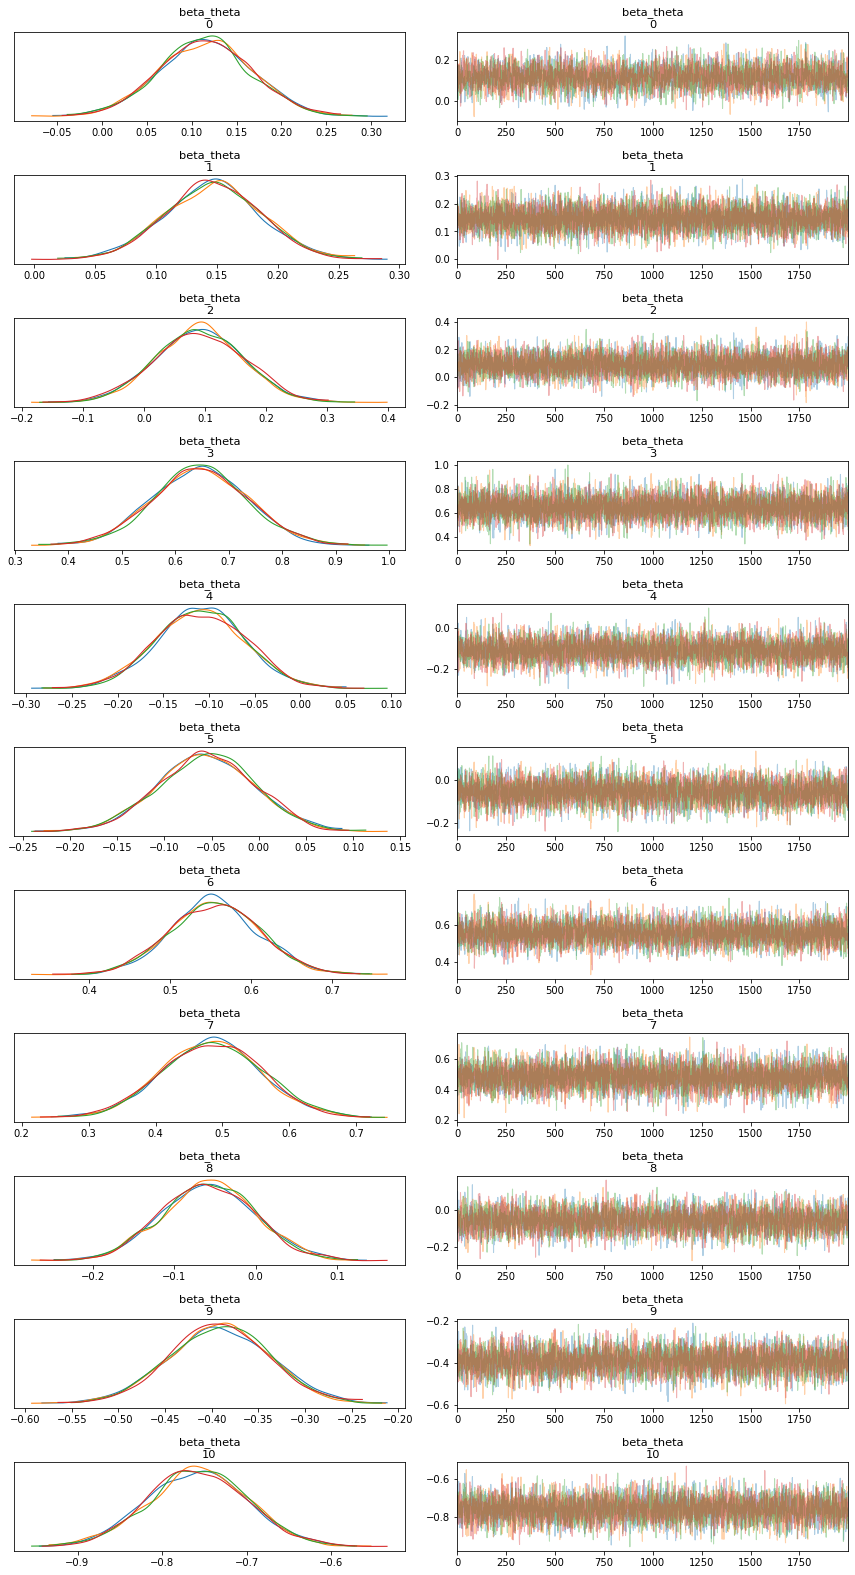

In [ ]:
cmdstanpy_data = az.from_cmdstanpy(stan_test_fit)
az.plot_trace(cmdstanpy_data,var_names=["beta_theta"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
# data save

az.to_netcdf(data = cmdstanpy_data, filename = '2y_12c_f1.dat')

## Covariate selection (Hard Shrinkage 95%)

Working with suitable absolutely continuous priors, we resort to sparse regression. We use Hard Shrinkage to see which covariates are actually relevant, i.e. we see which variables' 95% credibility intervals do not contain 0.

In [ ]:
stacked = az.hdi(cmdstanpy_data, hdi_prob = 0.95)

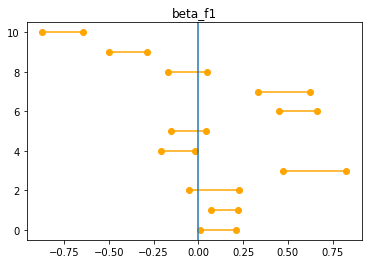

In [ ]:
# theta

stacked_np = stacked['beta_theta'].to_numpy()
num_beta = range(stacked_np.shape[0])
for interval, y in zip(stacked_np,num_beta):
  plt.plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
plt.axvline(0)
plt.title("beta_f1");

(baseline: unmarried, north-west, elementary school)

Positive effect: brings the individual not to travel

Negative effect: brings the individual to travel

Irrelevant covariates:

*   divorced
*   center
*   middle school

Positive effect:

*   married
*   widowed
*   south
*   islands

Negative effect:

*   north-east
*   high school
*   university

We then set out to inspect if the effect of the covariates differs between the 2019 and 2021.





## Time effect

In [ ]:
# STAN model

model_stan_full = """

    data {

      // number of samples
      int<lower=0> n_samples_trav;
      int<lower=0> n_samples_notrav;
      // number of covariates for theta / number of columns of X
      int<lower=0> p1;
      // covariates for theta 
      matrix[n_samples_trav,p1] X_trav_1;
      matrix[n_samples_trav,p1] X_trav_2;
      matrix[n_samples_notrav,p1] X_notrav_1;
      matrix[n_samples_notrav,p1] X_notrav_2;

    }

    parameters {

      vector[p1] beta_theta_raw_1;
      vector[p1] beta_theta_raw_2;

    }
    
    transformed parameters {

      // true beta_theta
      vector[p1] beta_theta_1;
      beta_theta_1 = 10.0 * beta_theta_raw_1;
      vector[p1] beta_theta_2;
      beta_theta_2 = 10.0 * beta_theta_raw_2;
      // theta computation
      vector[n_samples_trav] theta_trav_1;
      theta_trav_1 = X_trav_1 * beta_theta_1;
      vector[n_samples_notrav] theta_notrav_1;
      theta_notrav_1 = X_notrav_1 * beta_theta_1;
      vector[n_samples_trav] theta_trav_2;
      theta_trav_2 = X_trav_2 * beta_theta_2;
      vector[n_samples_notrav] theta_notrav_2;
      theta_notrav_2 = X_notrav_2 * beta_theta_2;

    }


    model {

      target += log(Phi_approx(theta_notrav_1));
      target += log1m(Phi_approx(theta_trav_1));
      target += log(Phi_approx(theta_notrav_2));
      target += log1m(Phi_approx(theta_trav_2));

      // priors: 
      beta_theta_raw_1 ~ std_normal();
      beta_theta_raw_2 ~ std_normal();

    }

"""

In [ ]:
stan_file = "./full_test.stan"

with open(stan_file, "w") as f:
    print(model_stan_full, file=f)

stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/full_test
09:56:54 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/full_test.stan to exe file /gdrive/MyDrive/full_test
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/full_test.stan to exe file /gdrive/MyDrive/full_test
DEBUG:cmdstanpy:cmd: make /gdrive/MyDrive/full_test
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/gdrive/MyDrive/full_test.hpp /gdrive/MyDrive/full_test.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno

In [ ]:
# "auto-format" flag to fix deprecated delcarations

stan_model.format(
    overwrite_file = True,
    canonicalize = True,
    # max_line_length = 78,
    backup = False
)

In [ ]:
# STAN data preparation

x_trav_1 = x_trav[:1300,:]
x_trav_2 = x_trav[-1300:,:]
x_pos_1 = x_pos[:1300,:]
x_pos_2 = x_pos[-1300:,:]
print(x_trav_1.shape,x_trav_2.shape)
print(x_pos_1.shape,x_pos_2.shape)

(1300, 11) (1300, 11)
(1300, 11) (1300, 11)


In [ ]:
stan_data = {
    "n_samples_trav": x_pos_1.shape[0],
    "n_samples_notrav": x_pos_1.shape[0],
    "p1": x_pos_1.shape[1],
    "X_trav_1": x_trav_1,
    "X_trav_2": x_trav_2,
    "X_notrav_1": x_pos_1,
    "X_notrav_2": x_pos_2,
}

In [ ]:
# STAN computations

stan_test_fit = stan_model.sample(data=stan_data, chains=4, parallel_chains=4, 
                             iter_warmup=3000, iter_sampling=2000,
                             adapt_delta=0.9,
                             inits = 0,
                             show_console=True)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcspjifga/qvjix_lw.json
DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/full_test info
cwd: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/full_test', 'id=1', 'random', 'seed=45796', 'data', 'file=/tmp/tmpcspjifga/qvjix_lw.json', 'init=0', 'output', 'file=/tmp/tmpcspjifga/full_testicatyke5/full_test-20221222095717_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=3000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
09:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/full_test', 'id=2', 'random', 'seed=45796', 'data', 'file=/tmp/tmpcspjifga/qvjix_lw.json', 'init=0', 'output', 'file=/tmp/tmpcspjifga/full_testicatyke5/full_test-20221222095717_2.csv', 'method=sample', 'num_samples=2000', 'num_warmup=3000', 'algor

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 2000
Chain [1] num_warmup = 3000
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.90000000000000002
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpcspjifga/qvjix_lw.json
Chain [1] init = 0
Chain [1] random
Chain [1] seed = 45796
Chain [1] output
Chain [1] file = /tmp/tmpcspjifga/full_testi

10:00:36 - cmdstanpy - INFO - Chain [3] done processing
INFO:cmdstanpy:Chain [3] done processing


Chain [3] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [3] 
Chain [3] Elapsed Time: 117.141 seconds (Warm-up)
Chain [3] 82.333 seconds (Sampling)
Chain [3] 199.474 seconds (Total)
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 


10:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Chain [1] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 119.967 seconds (Warm-up)
Chain [1] 79.775 seconds (Sampling)
Chain [1] 199.742 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Cha

10:00:37 - cmdstanpy - INFO - Chain [4] done processing
INFO:cmdstanpy:Chain [4] done processing


Chain [4] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [4] 
Chain [4] Elapsed Time: 118.847 seconds (Warm-up)
Chain [4] 81.282 seconds (Sampling)
Chain [4] 200.129 seconds (Total)
Chain [4] 
Chain [4] 


10:00:37 - cmdstanpy - INFO - Chain [2] done processing
INFO:cmdstanpy:Chain [2] done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/full_test', 'id=1', 'random', 'seed=45796', 'data', 'file=/tmp/tmpcspjifga/qvjix_lw.json', 'init=0', 'output', 'file=/tmp/tmpcspjifga/full_testicatyke5/full_test-20221222095717_1.csv', 'method=sample', 'num_samples=2000', 'num_warmup=3000', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.9']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcspjifga/full_testicatyke5/full_test-20221222095717_1.csv
 console_msgs (if any):
	/tmp/tmpcspjifga/full_testicatyke5/full_test-20221222095717_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 2000
    num_warmup = 3000
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default

Chain [2] Iteration: 5000 / 5000 [100%]  (Sampling)
Chain [2] 
Chain [2] Elapsed Time: 116.687 seconds (Warm-up)
Chain [2] 83.847 seconds (Sampling)
Chain [2] 200.534 seconds (Total)
Chain [2] 
Chain [2] 


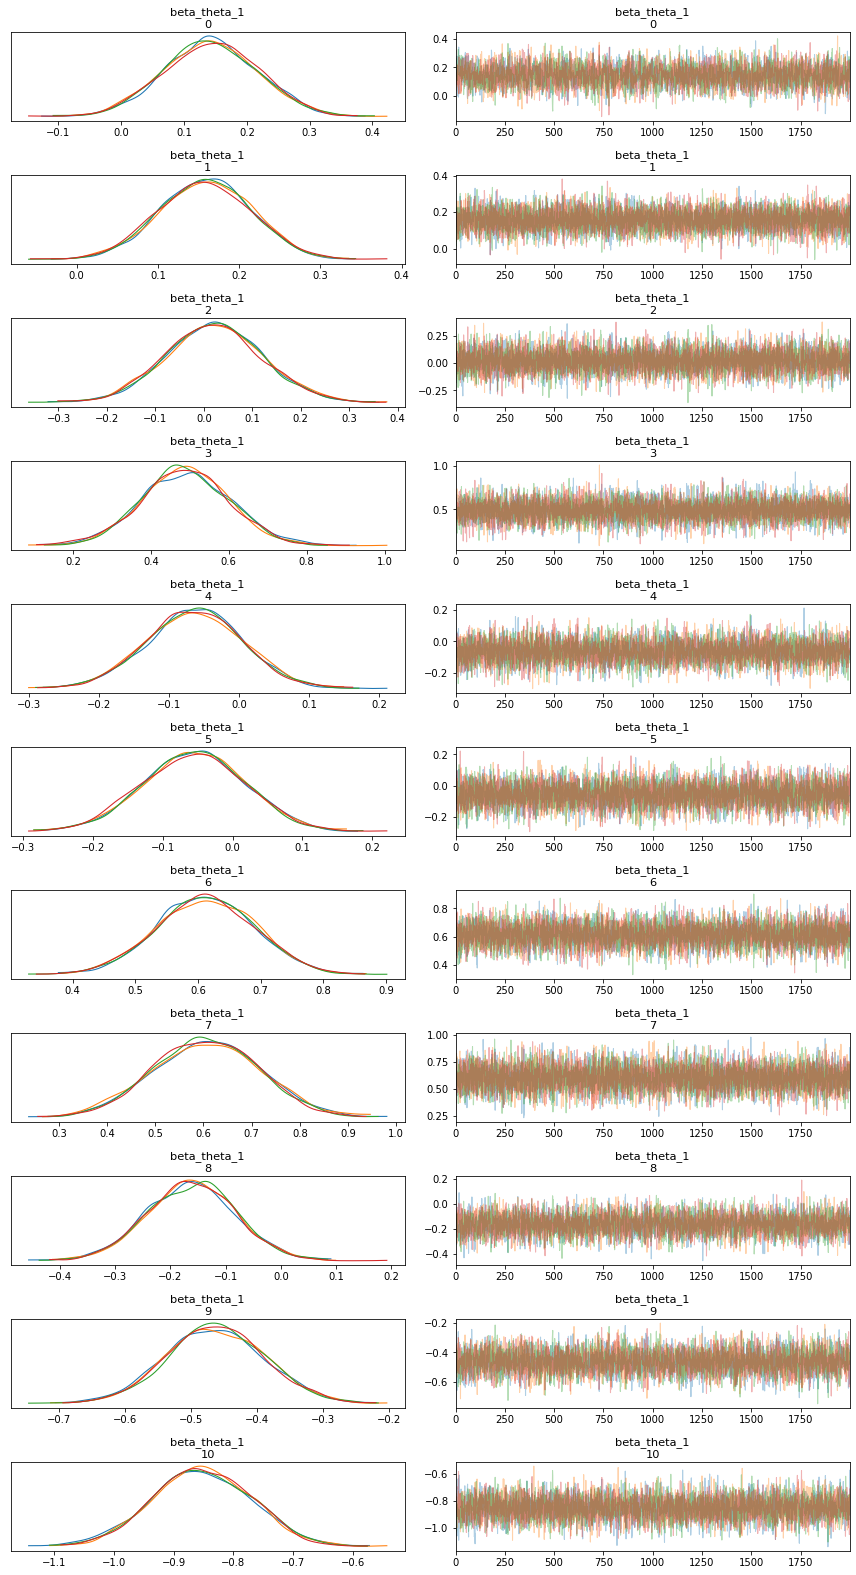

In [ ]:
cmdstanpy_data = az.from_cmdstanpy(stan_test_fit)
az.plot_trace(cmdstanpy_data,var_names=["beta_theta_1"], compact=False)
plt.tight_layout()
plt.show()

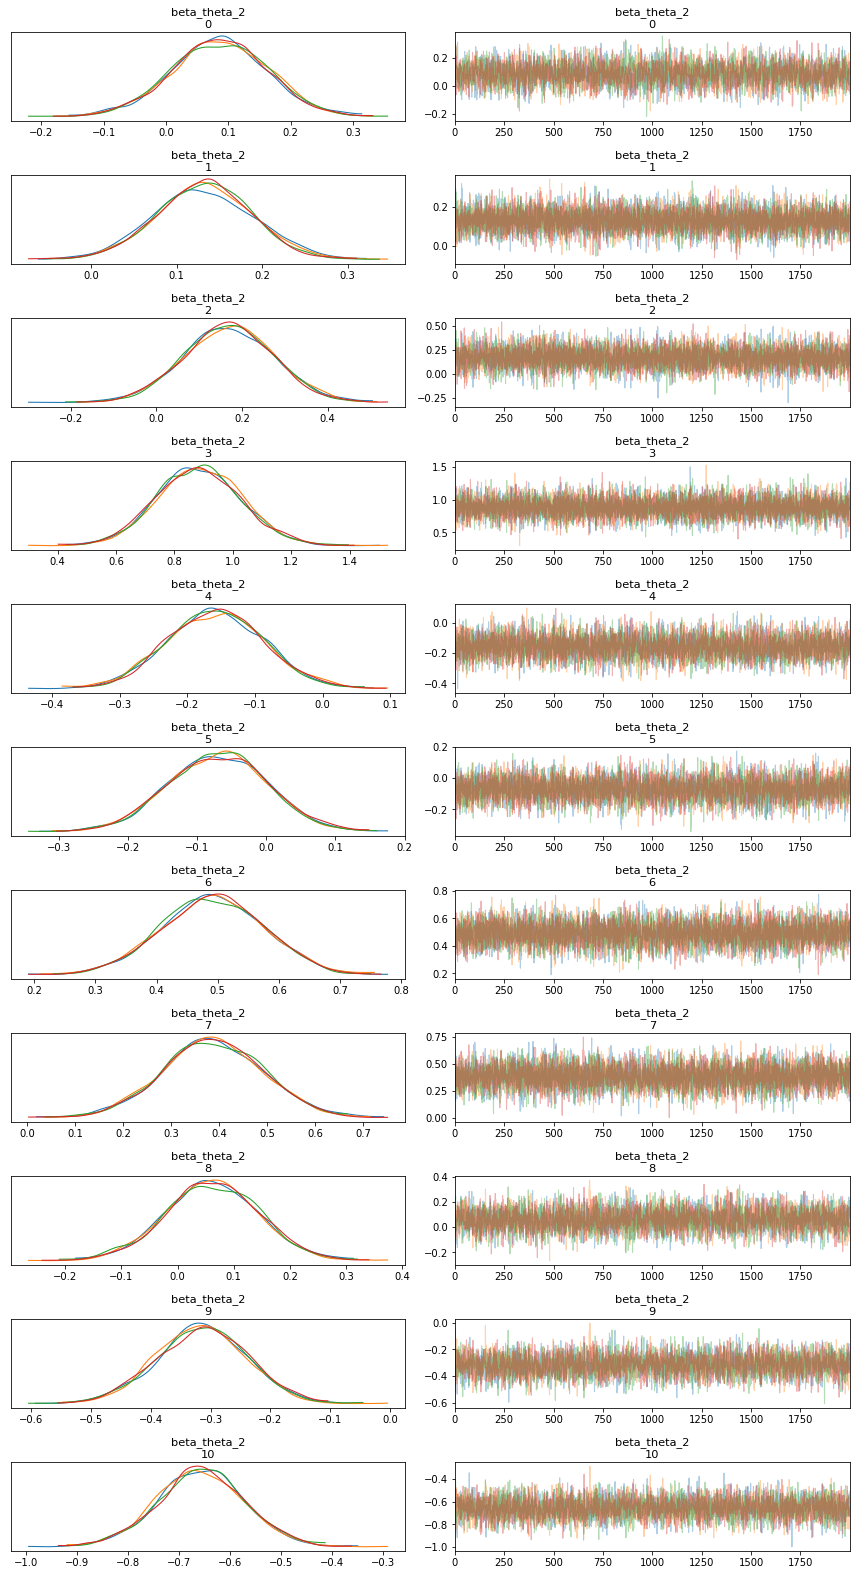

In [ ]:
az.plot_trace(cmdstanpy_data,var_names=["beta_theta_2"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
# data save

az.to_netcdf(data = cmdstanpy_data, filename = '2y_12c_hier_f1.dat')

## Conlcusions

In [ ]:
stacked = az.hdi(cmdstanpy_data, hdi_prob = 0.95)

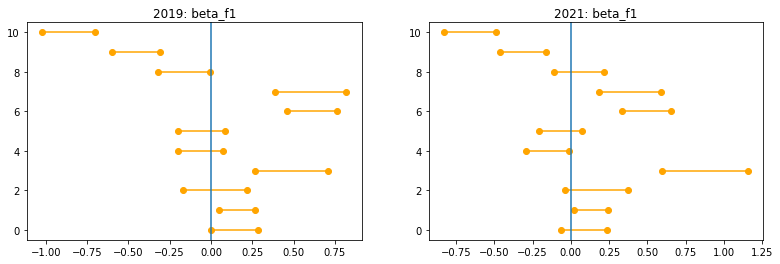

In [ ]:
# theta
stacked_np_1 = stacked['beta_theta_1'].to_numpy()
stacked_np_2 = stacked['beta_theta_2'].to_numpy()
num_beta = range(stacked_np_1.shape[0])
fig, axes = plt.subplots(1 , 2, figsize=(13.2, 4))
for interval, y in zip(stacked_np_1,num_beta):
  axes[0].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
axes[0].axvline(0)
axes[0].set_title("2019: beta_f1");
for interval, y in zip(stacked_np_2,num_beta):
  axes[1].plot((interval[0],interval[1]),(y,y),'ro-',color='orange')
axes[1].axvline(0)
axes[1].set_title("2021: beta_f1");

In terms of relevant covariates, the only difference is that being resident in the north-eastern part of Italy becomes non negligible in 2021 with a negative effect. (Possible explanation: being a region that has been particulaly struck by the pandemic and the related restrictions, a possible explanation for this change in tendencies could be that people were incentivized to travel more after being stuck at home for so long)

After two years, while mantaining the sign of the effect, most of the relevant covariates seem to present a general shift towards a non-travelling attitude, meaning towards more positive effects. Countering this tendency, people coming from the south and islands of the country seem to be less disincentivized to travel than before, possibly due to the many vacation options within the own region. (Possible explanation: there could be more possible explanations for this behavior, ranging from less disposable incomes due to economical crisis to travel restrictions still in effect in many parts of Italy)